Found 1084 files belonging to 2 classes.
client_1 will process images from index 0 to -1. Total images: 10


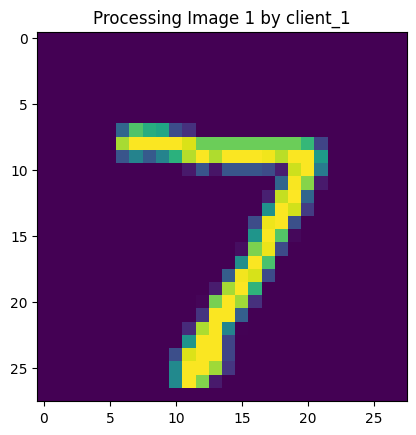

1/1 [==============================] - 0s 212ms/step


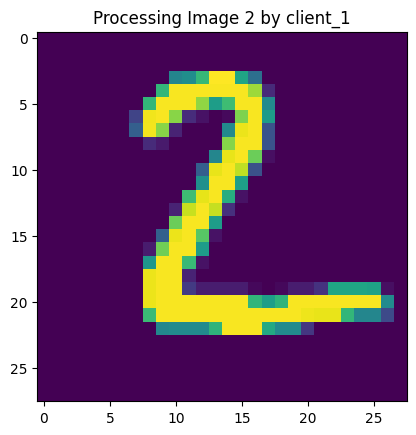

1/1 [==============================] - 0s 31ms/step


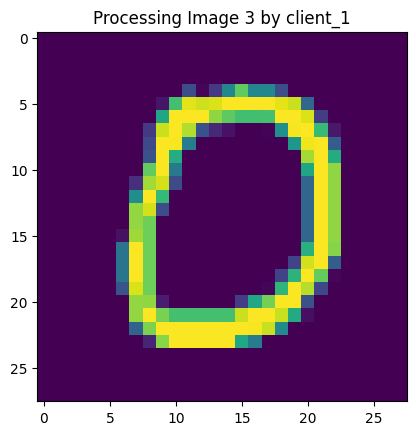

1/1 [==============================] - 0s 26ms/step


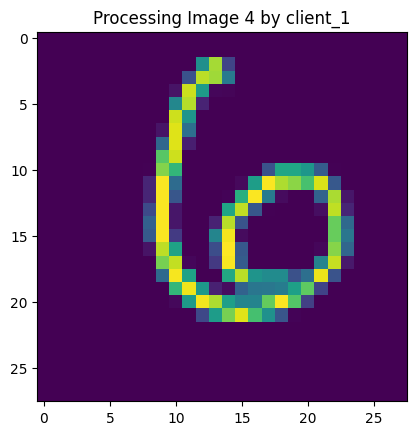

1/1 [==============================] - 0s 25ms/step


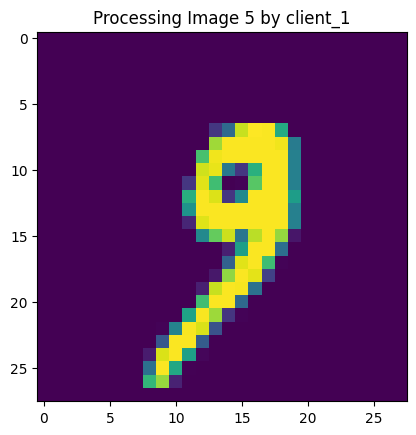

1/1 [==============================] - 0s 25ms/step


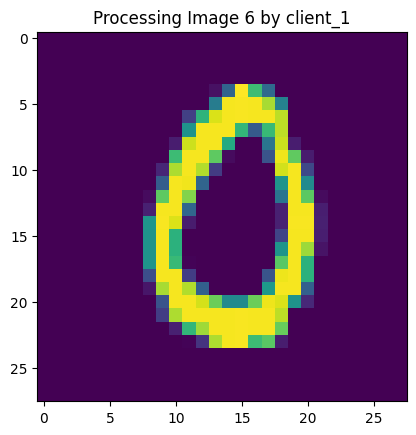

1/1 [==============================] - 0s 24ms/step


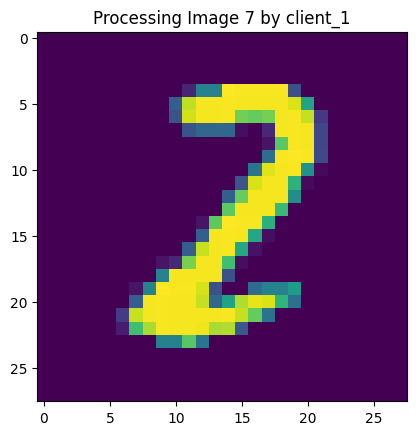

1/1 [==============================] - 0s 31ms/step


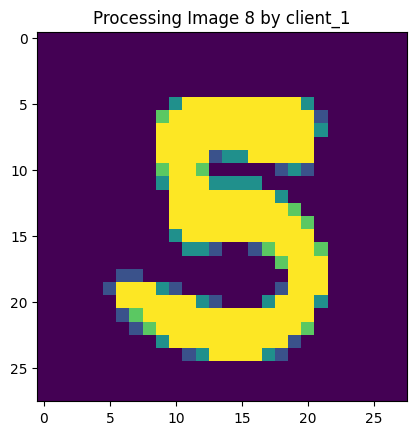

1/1 [==============================] - 0s 24ms/step


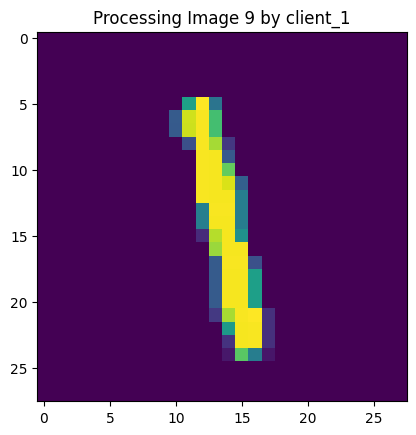

1/1 [==============================] - 0s 25ms/step


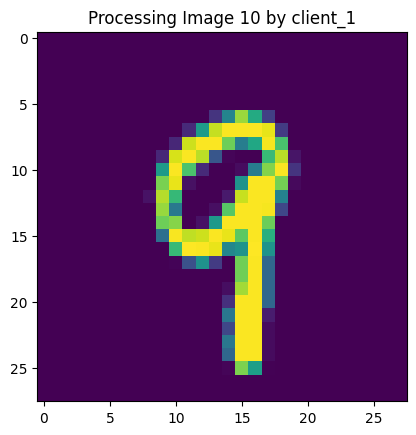

1/1 [==============================] - 0s 23ms/step
Labels received for client_1: [7, 2, 2, 6, 9, 2, 2, 5, 2, 9]
Total number of processed images by client_1: 10
Found 1084 files belonging to 2 classes.
client_2 will process images from index 0 to -1. Total images: 10


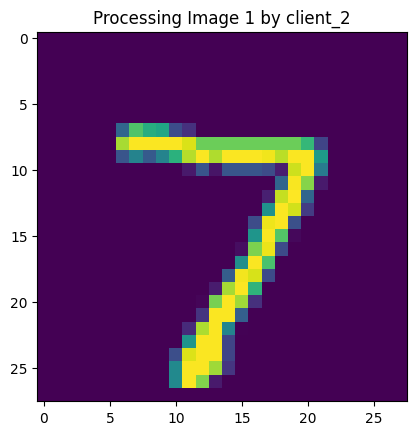

1/1 [==============================] - 0s 154ms/step


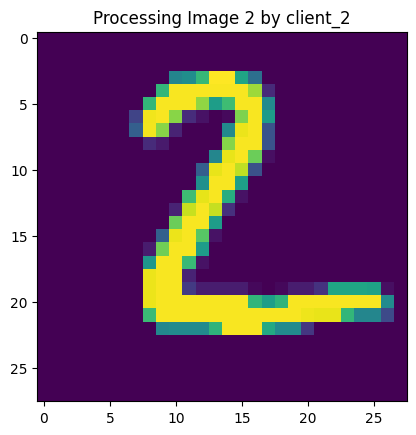

1/1 [==============================] - 0s 25ms/step


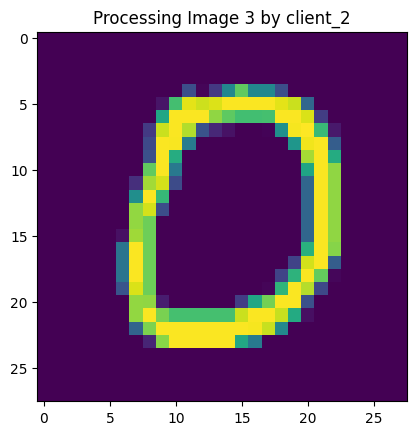

1/1 [==============================] - 0s 23ms/step


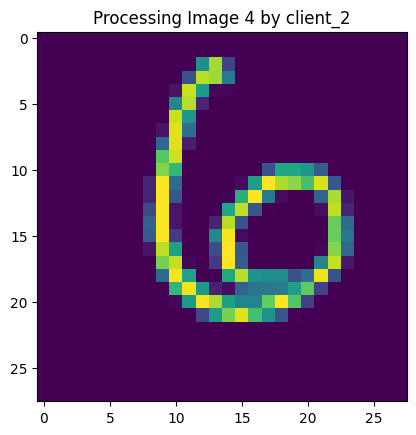

1/1 [==============================] - 0s 35ms/step


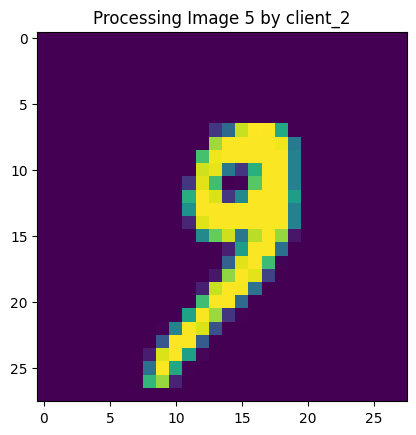

1/1 [==============================] - 0s 27ms/step


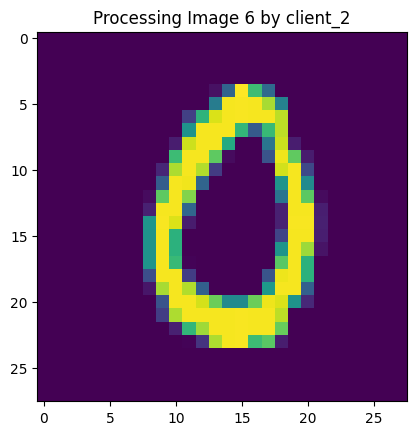

1/1 [==============================] - 0s 26ms/step


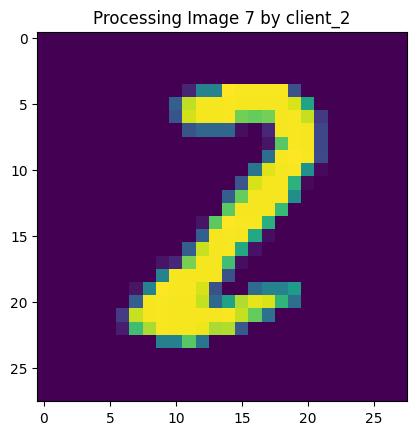

1/1 [==============================] - 0s 25ms/step


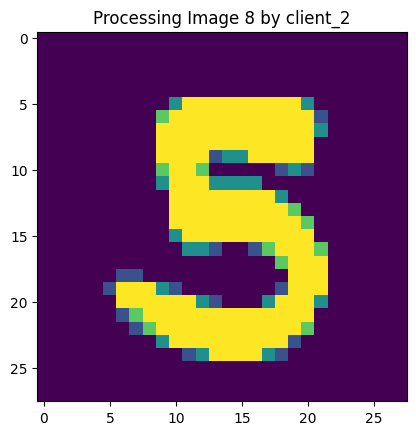

1/1 [==============================] - 0s 25ms/step


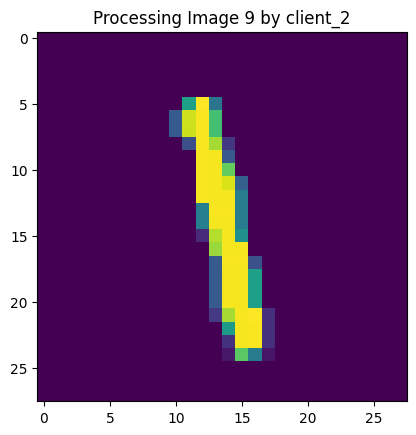

1/1 [==============================] - 0s 44ms/step


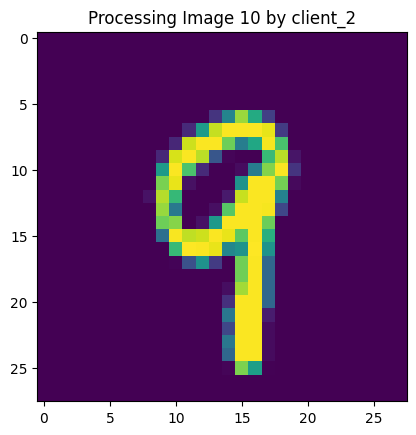

1/1 [==============================] - 0s 38ms/step
Labels received for client_2: [7, 2, 2, 6, 9, 2, 2, 5, 2, 9]
Total number of processed images by client_2: 10


In [15]:
import os
import requests
import tensorflow as tf
from PIL import Image
import zipfile
import math
import matplotlib.pyplot as plt


class Batchmaker:
    def __init__(self, model_url, dataset_url):
        self.default_model_url = model_url
        self.default_dataset_url = dataset_url
        self.batches = {}
        self.received_labels = {}  # Dictionary to store labels from each client

    def request_batch(self, eth_address):
        if eth_address not in self.batches:
            self.batches[eth_address] = {
                'model_url': self.default_model_url,
                'dataset_url': self.default_dataset_url,
            }
        # Initialize the received labels list for this client
        if eth_address not in self.received_labels:
            self.received_labels[eth_address] = []
        return self.batches[eth_address]

    def receive_labels(self, eth_address, labels):
        if eth_address in self.batches:
            # Append the labels received from this client to its specific array
            self.received_labels[eth_address].extend(labels)
            print(f"Labels received for {eth_address}: {labels}")
        else:
            print(f"Batch not found for the provided ETH address: {eth_address}")


class Client:
    def __init__(self, eth_address, batchmaker):
        self.eth_address = eth_address
        self.batchmaker = batchmaker
        self.model = None
        self.dataset = None
        self.start_index = 0
        self.end_index = 0

    # Other methods (_download_file, _extract_zip, _filter_images, getClientModel) remain unchanged...
    def _download_file(self, url, destination_path):
        if "drive.google.com" in url:
            file_id = url.split('/d/')[1].split('/')[0]
            url = f"https://drive.google.com/uc?export=download&id={file_id}"
        response = requests.get(url, stream=True)
        with open(destination_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=128):
                f.write(chunk)

    def _extract_zip(self, file_path, extract_path):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

    def _filter_images(self, directory):
        for subdir, dirs, files in os.walk(directory):
            for file in files:
                file_path = os.path.join(subdir, file)
                try:
                    Image.open(file_path)
                except (IOError, SyntaxError):
                    #print(f'Removing non-image file: {file_path}')
                    os.remove(file_path)

    def getClientModel(self, model_url):
        model_path = 'mnist_digit_model'
        self._download_file(model_url, model_path)
        self.model = tf.keras.models.load_model(model_path)

    def getDataset(self, dataset_url):
        dataset_zip_path = 'mnist_digit_model.zip'
        dataset_extract_path = 'mnist_digit_dataset'
        self._download_file(dataset_url, dataset_zip_path)
        self._extract_zip(dataset_zip_path, dataset_extract_path)
        self._filter_images(dataset_extract_path)

        # Disable shuffling and set a fixed batch size
        self.dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_extract_path,
            color_mode='grayscale',
            image_size=(28, 28),
            batch_size=16,  # Set batch size to 100
            shuffle=False  # Disable shuffling to maintain the order
        )

    def request_and_load_batch(self):
        batch_info = self.batchmaker.request_batch(self.eth_address)
        self.getClientModel(batch_info['model_url'])
        # Call getDataset with only the necessary dataset_url
        self.getDataset(batch_info['dataset_url'])

    def startMining(self):
        if not self.model or not self.dataset:
            raise ValueError("Model or dataset not loaded")

        predictions = []
        total_images_to_process = 10

        print(f"{self.eth_address} will process images from index {self.start_index} to {self.end_index - 1}. Total images: {total_images_to_process}")

        processed_images = 0
        for images_batch, _ in self.dataset:
            for image in images_batch:
                if processed_images >= total_images_to_process:
                    break

                plt.imshow(image.numpy().astype("uint8"))
                plt.title(f"Processing Image {processed_images + 1} by {self.eth_address}")
                plt.show()

                # Predict each image individually
                pred = self.model.predict(tf.expand_dims(image, 0))  # Add batch dimension
                prediction = tf.argmax(pred, axis=1).numpy()[0]  # Get the prediction for the single image
                predictions.append(prediction)
                processed_images += 1

            if processed_images >= total_images_to_process:
                break

        self.batchmaker.receive_labels(self.eth_address, predictions)
        print(f"Total number of processed images by {self.eth_address}: {len(predictions)}")
        return predictions

# Usage example

batchmaker = Batchmaker(
    'https://huggingface.co/spaces/ayaanzaveri/mnist/resolve/c959fe1db8b15ed643b91856cb2db4e2a3125938/mnist-model.h5',
    'https://drive.google.com/file/d/1P6kHVYGYd7xUTa6bW_37rdY4QHb9NDYa/view?usp=sharing'
)

# Create clients and assign them batches
clients = [Client(f'client_{i+1}', batchmaker) for i in range(2)]
for client in clients:
    client.request_and_load_batch()
    labels = client.startMining()


In [16]:
from abc import ABC, abstractmethod
from collections import Counter

class Consensus(ABC):
    @abstractmethod
    def receiveData(self, data):
        """
        Receive data like different clients' label arrays.
        """
        pass

    @abstractmethod
    def responseData(self):
        """
        Return the new array after consolidating labels.
        """
        pass

class ImageLabelConsensus(Consensus):
    def __init__(self):
        self.received_labels = {}

    def receiveData(self, data):
        """
        Stores the received data. Expected format: {client_id: [labels]}
        """
        self.received_labels = data

    def responseData(self):
        """
        Consolidates the received label data and returns a new array with the most common labels.
        """
        if not self.received_labels:
            return []

        label_length = len(next(iter(self.received_labels.values())))
        consolidated_labels = []

        for i in range(label_length):
            ith_labels = [labels[i] for labels in self.received_labels.values()]
            most_common_label = Counter(ith_labels).most_common(1)[0][0]
            consolidated_labels.append(most_common_label)

        return consolidated_labels

# Example usage:
image_label_consensus = ImageLabelConsensus()

# Simulating the receipt of data from different clients
image_label_consensus.receiveData({
    'client_1': batchmaker.received_labels['client_1'],
    'client_2': batchmaker.received_labels['client_2'],

})

consolidated_labels = image_label_consensus.responseData()
print("Consolidated Labels:", consolidated_labels)


Consolidated Labels: [7, 2, 2, 6, 9, 2, 2, 5, 2, 9]


Found 223 files belonging to 2 classes.
client_1 will process images from index 0 to -1. Total images: 10


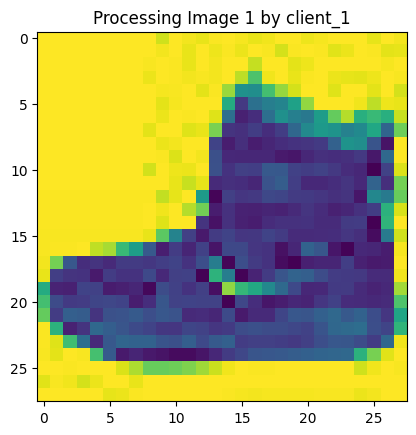

1/1 [==============================] - 0s 74ms/step


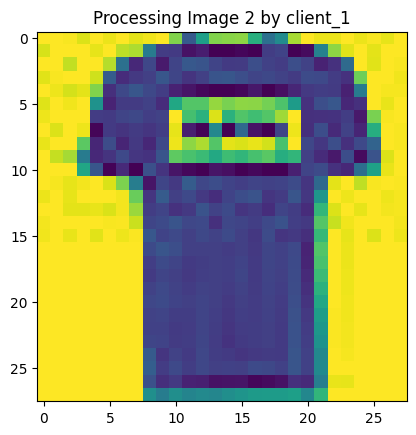

1/1 [==============================] - 0s 22ms/step


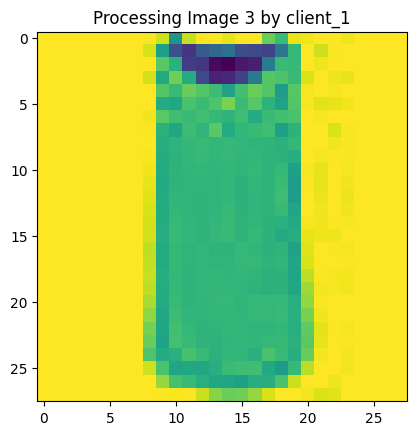

1/1 [==============================] - 0s 23ms/step


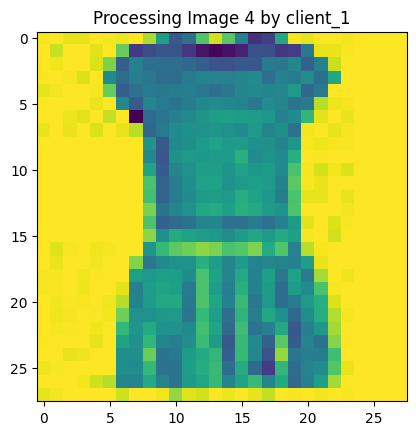

1/1 [==============================] - 0s 23ms/step


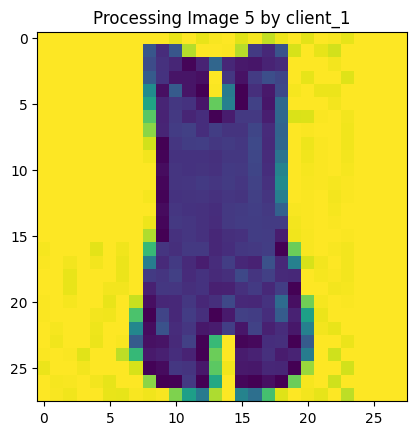

1/1 [==============================] - 0s 25ms/step


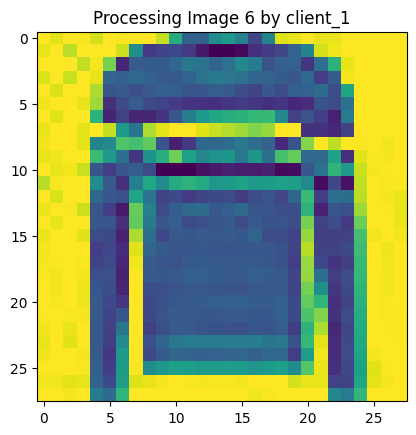

1/1 [==============================] - 0s 28ms/step


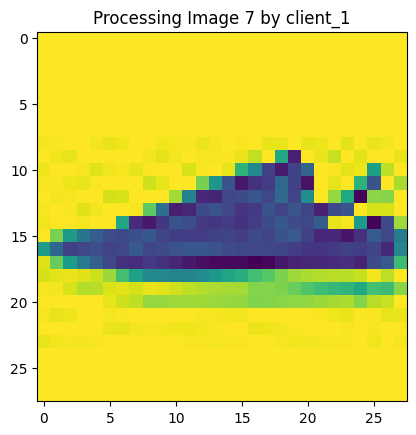

1/1 [==============================] - 0s 23ms/step


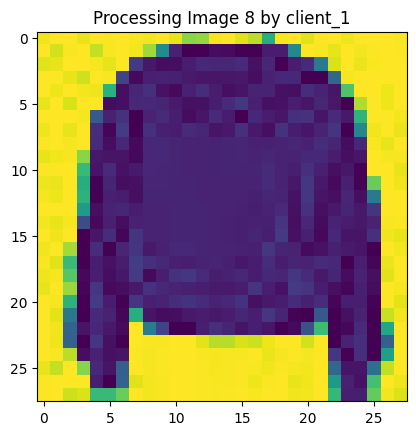

1/1 [==============================] - 0s 23ms/step


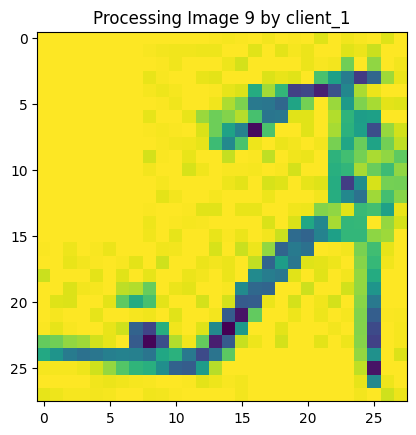

1/1 [==============================] - 0s 23ms/step


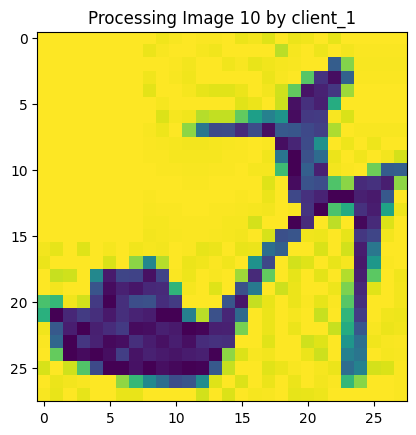

1/1 [==============================] - 0s 22ms/step
Labels received for client_1: [8, 8, 8, 8, 6, 8, 8, 8, 8, 8]
Total number of processed images by client_1: 10


Found 223 files belonging to 2 classes.
client_2 will process images from index 0 to -1. Total images: 10


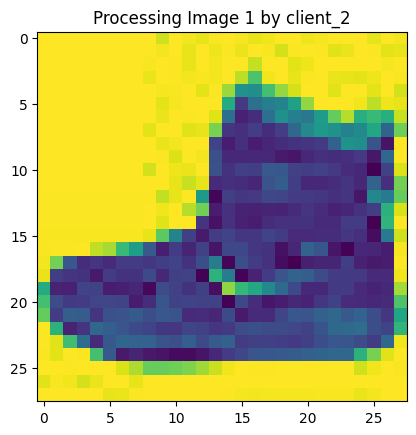

1/1 [==============================] - 0s 92ms/step


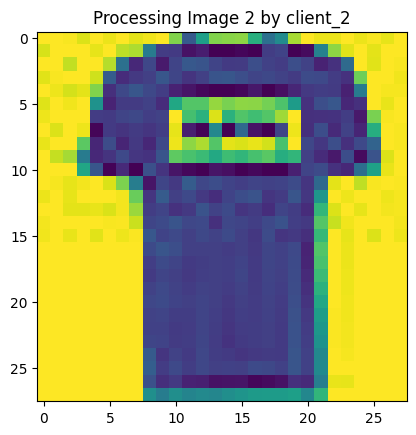

1/1 [==============================] - 0s 23ms/step


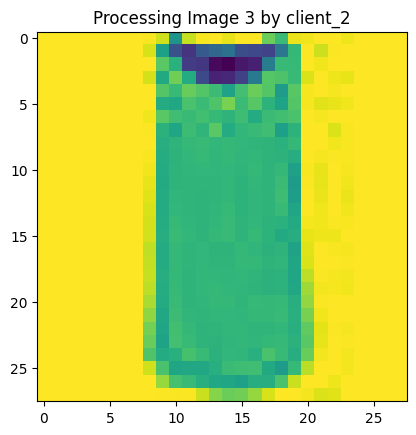

1/1 [==============================] - 0s 25ms/step


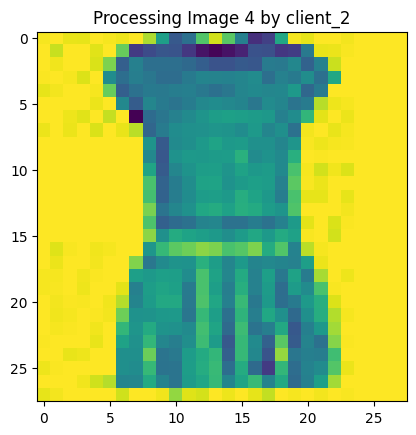

1/1 [==============================] - 0s 23ms/step


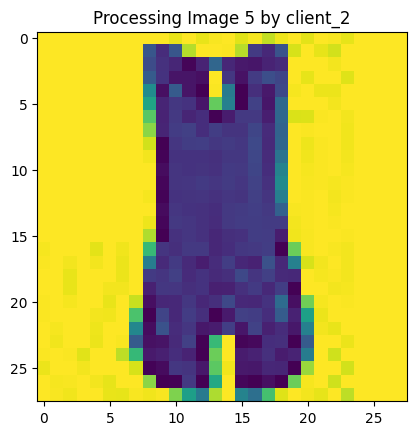

1/1 [==============================] - 0s 22ms/step


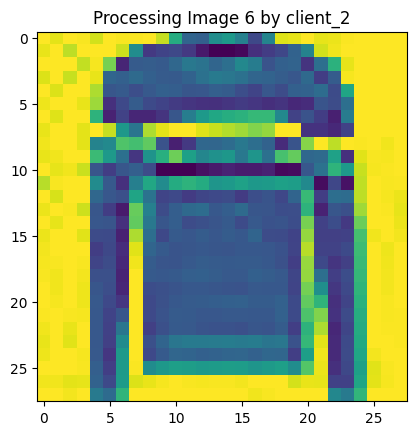

1/1 [==============================] - 0s 23ms/step


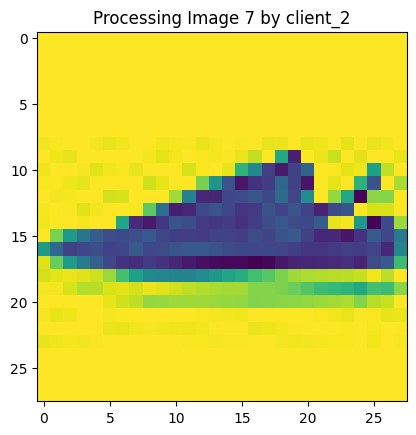

1/1 [==============================] - 0s 22ms/step


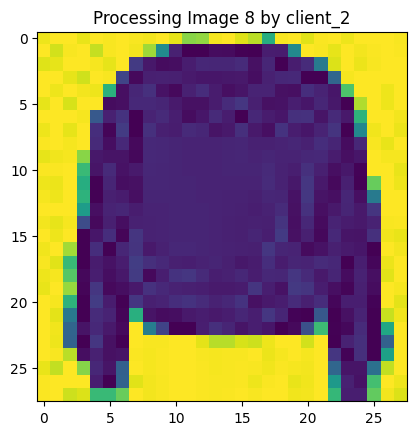

1/1 [==============================] - 0s 22ms/step


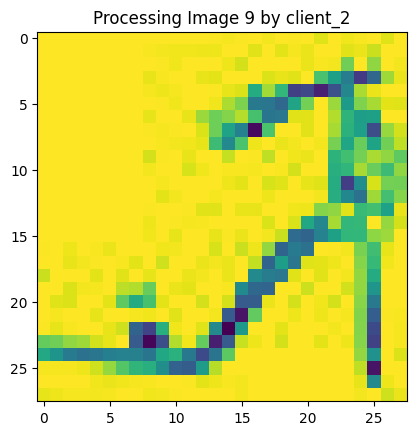

1/1 [==============================] - 0s 24ms/step


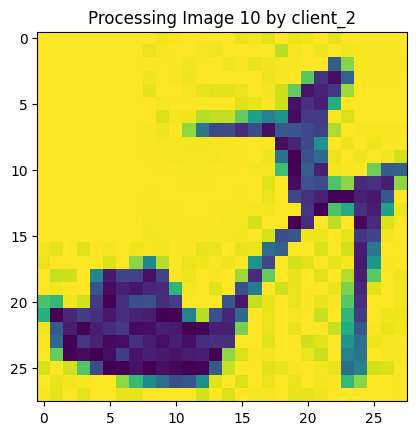

1/1 [==============================] - 0s 22ms/step
Labels received for client_2: [8, 8, 8, 8, 6, 8, 8, 8, 8, 8]
Total number of processed images by client_2: 10


In [20]:
import os
import requests
import tensorflow as tf
from PIL import Image
import zipfile
import math
import matplotlib.pyplot as plt


class Batchmaker:
    def __init__(self, model_url, dataset_url):
        self.default_model_url = model_url
        self.default_dataset_url = dataset_url
        self.batches = {}
        self.received_labels = {}  # Dictionary to store labels from each client

    def request_batch(self, eth_address):
        if eth_address not in self.batches:
            self.batches[eth_address] = {
                'model_url': self.default_model_url,
                'dataset_url': self.default_dataset_url,
            }
        # Initialize the received labels list for this client
        if eth_address not in self.received_labels:
            self.received_labels[eth_address] = []
        return self.batches[eth_address]

    def receive_labels(self, eth_address, labels):
        if eth_address in self.batches:
            # Append the labels received from this client to its specific array
            self.received_labels[eth_address].extend(labels)
            print(f"Labels received for {eth_address}: {labels}")
        else:
            print(f"Batch not found for the provided ETH address: {eth_address}")


class Client:
    def __init__(self, eth_address, batchmaker):
        self.eth_address = eth_address
        self.batchmaker = batchmaker
        self.model = None
        self.dataset = None
        self.start_index = 0
        self.end_index = 0

    # Other methods (_download_file, _extract_zip, _filter_images, getClientModel) remain unchanged...
    def _download_file(self, url, destination_path):
        if "drive.google.com" in url:
            file_id = url.split('/d/')[1].split('/')[0]
            url = f"https://drive.google.com/uc?export=download&id={file_id}"
        response = requests.get(url, stream=True)
        with open(destination_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=128):
                f.write(chunk)

    def _extract_zip(self, file_path, extract_path):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

    def _filter_images(self, directory):
        for subdir, dirs, files in os.walk(directory):
            for file in files:
                file_path = os.path.join(subdir, file)
                try:
                    Image.open(file_path)
                except (IOError, SyntaxError):
                    #print(f'Removing non-image file: {file_path}')
                    os.remove(file_path)

    def getClientModel(self, model_url):
        model_path = 'fashion_models'
        self._download_file(model_url, model_path)
        self.model = tf.keras.models.load_model(model_path)

    def getDataset(self, dataset_url):
        dataset_zip_path = 'fashion_models.zip'
        dataset_extract_path = 'fashion_dataset'
        self._download_file(dataset_url, dataset_zip_path)
        self._extract_zip(dataset_zip_path, dataset_extract_path)
        self._filter_images(dataset_extract_path)

        # Disable shuffling and set a fixed batch size
        self.dataset = tf.keras.preprocessing.image_dataset_from_directory(
            dataset_extract_path,
            color_mode='grayscale',
            image_size=(28, 28),
            batch_size=16,  # Set batch size to 100
            shuffle=False  # Disable shuffling to maintain the order
        )

    def request_and_load_batch(self):
        batch_info = self.batchmaker.request_batch(self.eth_address)
        self.getClientModel(batch_info['model_url'])
        # Call getDataset with only the necessary dataset_url
        self.getDataset(batch_info['dataset_url'])

    def startMining(self):
        if not self.model or not self.dataset:
            raise ValueError("Model or dataset not loaded")

        predictions = []
        total_images_to_process = 10

        print(f"{self.eth_address} will process images from index {self.start_index} to {self.end_index - 1}. Total images: {total_images_to_process}")

        processed_images = 0
        for images_batch, _ in self.dataset:
            for image in images_batch:
                if processed_images >= total_images_to_process:
                    break

                plt.imshow(image.numpy().astype("uint8"))
                plt.title(f"Processing Image {processed_images + 1} by {self.eth_address}")
                plt.show()

                # Predict each image individually
                pred = self.model.predict(tf.expand_dims(image, 0))  # Add batch dimension
                prediction = tf.argmax(pred, axis=1).numpy()[0]  # Get the prediction for the single image
                predictions.append(prediction)
                processed_images += 1

            if processed_images >= total_images_to_process:
                break

        self.batchmaker.receive_labels(self.eth_address, predictions)
        print(f"Total number of processed images by {self.eth_address}: {len(predictions)}")
        return predictions

# Usage example

batchmaker = Batchmaker(
    'https://drive.google.com/file/d/1vVFcTbKpi_XG04RafI1pl2v0s16Hlheq/view?usp=sharing',
    'https://drive.google.com/file/d/1Kx6JyGj9vpWUX6LpzYMbaXYysZSTp8zE/view?usp=sharing'
)

# Create clients and assign them batches
clients = [Client(f'client_{i+1}', batchmaker) for i in range(2)]
for client in clients:
    client.request_and_load_batch()
    labels = client.startMining()


In [21]:
from abc import ABC, abstractmethod
from collections import Counter

class Consensus(ABC):
    @abstractmethod
    def receiveData(self, data):
        """
        Receive data like different clients' label arrays.
        """
        pass

    @abstractmethod
    def responseData(self):
        """
        Return the new array after consolidating labels.
        """
        pass

class ImageLabelConsensus(Consensus):
    def __init__(self):
        self.received_labels = {}

    def receiveData(self, data):
        """
        Stores the received data. Expected format: {client_id: [labels]}
        """
        self.received_labels = data

    def responseData(self):
        """
        Consolidates the received label data and returns a new array with the most common labels.
        """
        if not self.received_labels:
            return []

        label_length = len(next(iter(self.received_labels.values())))
        consolidated_labels = []

        for i in range(label_length):
            ith_labels = [labels[i] for labels in self.received_labels.values()]
            most_common_label = Counter(ith_labels).most_common(1)[0][0]
            consolidated_labels.append(most_common_label)

        return consolidated_labels

# Example usage:
image_label_consensus = ImageLabelConsensus()

# Simulating the receipt of data from different clients
image_label_consensus.receiveData({
    'client_1': batchmaker.received_labels['client_1'],
    'client_2': batchmaker.received_labels['client_2']
})

consolidated_labels = image_label_consensus.responseData()
print("Consolidated Labels:", consolidated_labels)


Consolidated Labels: [8, 8, 8, 8, 6, 8, 8, 8, 8, 8]
